<a href="https://colab.research.google.com/github/sysu17363098/CS231n/blob/master/Attn_Model_For_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[For Test] Wikipedia Image Caption With Attention**

***LINKS:***
Dataset:[google drive dataset](https://drive.google.com/file/d/1lSFcL77kvPAJARGtCdTwqjBS-saJbjGv/view?usp=sharing)


model parameters(pretrained):[model google drive](https://drive.google.com/file/d/1-8nxP_0cnC9hjT-7h8DsHSyBPDa_rgB9/view?usp=share_link)

## **Install Required Libraries & load google drive**

In [ ]:
!pip install git+https://github.com/rwightman/pytorch-image-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwightman/pytorch-image-models to /tmp/pip-req-build-khnacaxx
  Running command git clone -q https://github.com/rwightman/pytorch-image-models /tmp/pip-req-build-khnacaxx
     |████████████████████████████████| 182 kB 21.4 MB/s 
  Created wheel for timm: filename=timm-0.7.0.dev0-py3-none-any.whl size=560593 sha256=e13a010ea39a1c112fef493604b07d5f5a2a2b054687d924c32c05e7f49fcac7
  Stored in directory: /tmp/pip-ephem-wheel-cache-06v4r8_b/wheels/69/3d/b0/be55cbadabd87a0e1875d63c7492d199097a39cc2433637650
Successfully built timm


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 30.5 MB/s 
     |████████████████████████████████| 7.6 MB 46.0 MB/s 


In [ ]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import Required Libraries**

In [ ]:
import os
import gc
import cv2
import copy
import time
import random
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import base64
import pickle

# For downloading images
from io import BytesIO

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

# For Image Models
import timm

# For Transformer Models
!pip install transformers
from transformers import AutoTokenizer, AutoModel
from transformers import AutoFeatureExtractor, SwinModel

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Configuration**

In [ ]:
CONFIG = {"seed": 2022,
      "epochs": 50,
      "img_size": 256,
      "image_model_name": "swin", # "tf_efficientnet_b0"
      "text_model_name": "xlm-roberta-base",
      "embedding_size": 768,
      "train_batch_size": 32,
      "valid_batch_size": 64,
      "learning_rate": 1e-3,
      "scheduler": 'CosineAnnealingLR',
      "min_lr": 1e-5,
      "T_max": 500,
      "weight_decay": 1e-6,
      "max_length": 32,
      "n_accumulate": 1,
      "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
      "root": "/content/drive/MyDrive/BDT SEM 1/ImageCaptionMatching/training/"
      }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['text_model_name'])

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

## **Dataset**

#### **Dataset Structure**

data: list of dictionaries
*   b64_bytes: base64 encoded bytes of the image file at a 300px resolution

*   caption_title_and_reference_description: list of captions
*   filename: filename of the image

links:[dataset](https://drive.google.com/file/d/1lSFcL77kvPAJARGtCdTwqjBS-saJbjGv/view?usp=sharing)



#### *Load & Split the Dataset*

In [ ]:
import pickle
filepath = "/content/drive/MyDrive/dataset.pkl"
with open(filepath, "rb") as fp:
  data = pickle.load(fp)

In [ ]:
print("size of the whole data:",len(data))

size of the whole data: 97052


split and shuffle the data

In [ ]:
import random
random.shuffle(data)

train_data = data[:45000]
valid_data = data[45000:60000]
test_data = data[60000:]
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(valid_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 45000
Number of validation samples: 15000
Number of test samples: 37052


In [ ]:
valid_data[1]

{'caption_title_and_reference_description': ['Zebedeo kaj lia edzino Maria Saloma kaj la filoj Sankta Johano la Evangeliisto kaj Jakobo la pli aĝa, Langenzenn (Bavario), (1508).',
  'Zebedeo [SEP] Zebedeo y su esposa María Salomé con sus hijos Juan y Jacobo (Santiago), Langenzenn (Baviera), (1508).',
  'Zebedäus mit sien Fru Maria Salome un sien Kinner Johannes un Jakobus de Öllere, Altar der Heiligen Sippe, Langenzenn (Bayern)',
  'Maria Salome mit ihrem Mann Zebedäus und ihren Kindern Johannes Evangelista und Jakobus maior, Altar der Heiligen Sippe, Langenzenn (Bayern)'],
 'b64_bytes': '/9j/4AAQSkZJRgABAQEASABIAAD//gBoRmlsZSBzb3VyY2U6IGh0dHA6Ly9jb21tb25zLndpa2ltZWRpYS5vcmcvd2lraS9GaWxlOkxhbmdlbnplbm5fU3RhZHRraXJjaGVfLV9BbHRhcl9IZWlsaWdlX1NpcHBlXzUuanBn/9sAQwAGBAUGBQQGBgUGBwcGCAoQCgoJCQoUDg8MEBcUGBgXFBYWGh0lHxobIxwWFiAsICMmJykqKRkfLTAtKDAlKCko/9sAQwEHBwcKCAoTCgoTKBoWGigoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgo/8AAEQgBwQEsAwEhAAIRAQMRAf/EAB0AAAEFAQEBAQAAAAAAAAAA

#### *Prepare the DataLoader*

图像增强

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()
        ], p=1.),

    "valid": A.Compose([
        A.Resize(256, 256),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()
        ], p=1.)
}

自定义数据集

In [ ]:
class WikipediaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, transforms=None):
        self.data = data
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.transforms = transforms


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # image
        image_bytes = base64.b64decode(self.data[index]['b64_bytes'])
        img = np.asarray(Image.open(BytesIO(image_bytes)).convert('RGB'))

        if self.transforms:
            img = self.transforms(image=img)['image']

        # caption
        caption = random.choice(self.data[index]['caption_title_and_reference_description'])
        caption = caption.replace('[SEP]', '</s>') # sep token for xlm-roberta
        inputs = self.tokenizer.encode_plus(
                caption,
                truncation=True,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length'
            )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        # filename
        filename = self.data[index]['filename']
        filename = filename.replace('[SEP]', '</s>') # sep token for xlm-roberta
        encode_name = self.tokenizer.encode_plus(
                filename,
                truncation=True,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length'
            )
        name_ids = encode_name['input_ids']
        name_mask = encode_name['attention_mask']


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'image': img,
            'name_ids': torch.tensor(name_ids, dtype=torch.long),
            'name_mask': torch.tensor(name_mask, dtype=torch.long)
        }

Build the DataLoader for training set and validation set

In [ ]:
train_dataset = WikipediaDataset(
    train_data,
    CONFIG["tokenizer"],
    CONFIG["max_length"],
    transforms=data_transforms["train"]
    )
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['train_batch_size'],
    num_workers=4, shuffle=True, pin_memory=True, drop_last=True)

valid_dataset = WikipediaDataset(
    valid_data,
    CONFIG["tokenizer"],
    CONFIG["max_length"],
    transforms=data_transforms["valid"]
    )
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'],
                          num_workers=4, shuffle=False, pin_memory=True)

In [ ]:
print(train_dataset[0])

## **Model Architecture**

### Swin + Xlm-roberta + Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, feat_dim, attention=None, ffn=None, last_norm=True):
        super(Attention, self).__init__()

        self.att = attention if attention else nn.MultiheadAttention(embed_dim=feat_dim, num_heads=8)
        self.norm = nn.LayerNorm(feat_dim)
        self.ffn = ffn if ffn else nn.Sequential(nn.Linear(feat_dim, 1024), nn.ReLU(inplace=True), nn.Linear(1024, feat_dim))
        self.last_norm = nn.LayerNorm(feat_dim) if last_norm else (lambda x: x)

    def forward(self, q, k, v, attention_mask=None):
        feat = self.att(q, k, v, attention_mask)[0]
        feat = self.norm(feat + q)
        feat = self.last_norm(feat + self.ffn(feat))
        return feat

In [ ]:
class WikipediaModel_Attention(nn.Module):
    def __init__(self, image_model, text_model, embedding_size, device):
        super(WikipediaModel_Attention, self).__init__()
        self.device = device

        # image feature extractor
        self.feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
        self.image_model = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224").to(self.device)

        # text(caption/filename) feature extractor
        self.text_model = AutoModel.from_pretrained(text_model)

        # Attention
        self.att1 = Attention(
            embedding_size,
            nn.MultiheadAttention(
                embed_dim=embedding_size,
                num_heads=8,
                kdim=768,
                vdim=768))
        self.att2 = Attention(embedding_size)
        self.att3 = Attention(embedding_size, last_norm=False)

        # fnn for caption
        self.norm = nn.LayerNorm(768)
        self.ffn = nn.Sequential(nn.Linear(768, 1024), nn.ReLU(inplace=True), nn.Linear(1024, 768))

        self.freeze_backbone()

    def forward(self, images, ids, mask, f_ids, f_mask):
        # image embedding
        # (batch, sq_len=49, emb_size=768)->(sq_len,batch,emb_size)
        image_embedding = self.image_model(images).last_hidden_state

        # caption embedding
        out = self.text_model(input_ids=ids,attention_mask=mask,
                              output_hidden_states=False)
        caption_embedding = out['pooler_output']
        caption_embedding = caption_embedding + self.ffn(caption_embedding)

        # filename embedding
        output = self.text_model(input_ids=f_ids, attention_mask=f_mask, output_hidden_states=False)
        seq_embedding = output['last_hidden_state'] # (batch_size, sequence_length, hidden_size)
        name_embedding = output['pooler_output'] # (batch_size, hidden_size)
        attention_mask = (1 - f_mask).bool()

        # attn
        if image_embedding.shape[0] != 1: # batch != 1
          image_embedding = image_embedding.squeeze().permute(1, 0, 2)
        else:
          image_embedding = image_embedding.permute(1, 0, 2)
        seq_embedding = seq_embedding.permute(1, 0, 2) # (sq_len,batch,emb_size)
        embedding = self.att1(seq_embedding, image_embedding, image_embedding)
        embedding = self.att2(embedding, embedding, embedding, attention_mask)

        name_embedding = name_embedding.unsqueeze(0)
        embedding = self.att3(name_embedding, embedding, embedding, attention_mask)

        return embedding.squeeze(0), caption_embedding

    def freeze_backbone(self):
        for params in self.image_model.parameters():
            params.requires_grad = False

        for params in self.text_model.parameters():
            params.requires_grad = False

## **Create Model Based on Architecture**

new model

In [ ]:
model = WikipediaModel_Attention(
    CONFIG['image_model_name'],
    CONFIG['text_model_name'],
    CONFIG['embedding_size'],
    CONFIG['device'])
model.to(CONFIG['device']);

Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


start from pretrained model

In [ ]:
model = WikipediaModel_Attention(
    CONFIG['image_model_name'],
    CONFIG['text_model_name'],
    CONFIG['embedding_size'],
    CONFIG['device']
    )
model.load_state_dict(torch.load("/content/drive/MyDrive/swin_xlm-roberta-base_attn_Loss0.0000_epoch4.bin"))
model.to(CONFIG['device']);

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another arc

RuntimeError: ignored

In [ ]:
print(model)

## **Loss Function(cos similarity)**

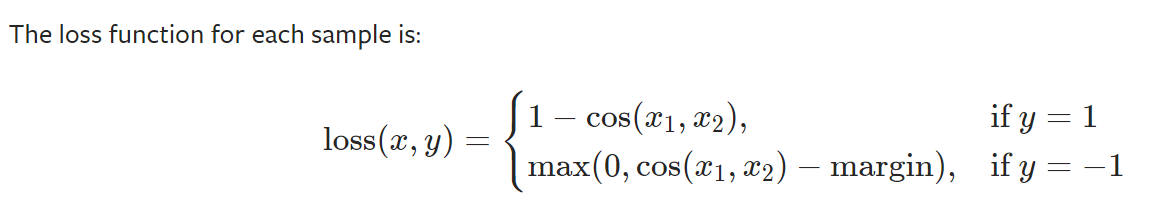

In [ ]:
def criterion(outputs1, outputs2, targets=1):
    target = torch.ones(outputs1.size()[0]).to(CONFIG['device'])
    return nn.CosineEmbeddingLoss()(outputs1, outputs2, target)

In [ ]:
#NDCG Test

In [ ]:
def dcg_score(y_true, y_score, k=10, gains="exponential"):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    if gains == "exponential":
        gains = 2 ** y_true - 1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError("Invalid gains option.")

    # highest rank is 1 so +2 instead of +1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)


def ndcg_score(y_true, y_score, k=10, gains="exponential"):
    best = dcg_score(y_true, y_true, k, gains)
    actual = dcg_score(y_true, y_score, k, gains)
    return actual / best

In [ ]:
num=len(test_data)

## How to use

In [ ]:
sum=0
for i in range(0,num):
  device = CONFIG['device']
  ids = test_data[i]['ids'].unsqueeze(0).to(device, dtype = torch.long)
  mask = test_data[i]['mask'].unsqueeze(0).to(device, dtype = torch.long)
  image = test_data[i]['image'].unsqueeze(0).to(device, dtype = torch.float)
  name_ids = test_data[i]['name_ids'].unsqueeze(0).to(device, dtype = torch.long)
  name_mask = test_data[i]['name_mask'].unsqueeze(0).to(device, dtype = torch.long)
  out1, out2 = model(image, ids, mask, name_ids, name_mask)
  sum+=criterion(out1, out2).item()
  #print(i)

avg=sum/num
print(avg)

NameError: ignored

In [ ]:
valid_dataset[1]

squeeze is used to increase a dimension as 'batch_size', if inputs are already a batch, just ignore it

In [ ]:
device = CONFIG['device']
ids = valid_dataset[2]['ids'].unsqueeze(0).to(device, dtype = torch.long)
mask = valid_dataset[2]['mask'].unsqueeze(0).to(device, dtype = torch.long)
image = valid_dataset[2]['image'].unsqueeze(0).to(device, dtype = torch.float)
name_ids = valid_dataset[2]['name_ids'].unsqueeze(0).to(device, dtype = torch.long)
name_mask = valid_dataset[2]['name_mask'].unsqueeze(0).to(device, dtype = torch.long)


In [ ]:
print(ids)

tensor([[     0, 183890,    476,  15114,  79609,  21046,  67421,   1082,  72181,
          41913,    652,   8809,  36080,   2351,      4,  68420,    103,  47720,
              2,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1]], device='cuda:0')


**input size:Tensor([bacth,……]) need batch**

In [ ]:
image.shape

torch.Size([1, 3, 256, 256])

In [ ]:
out1, out2 = model(image, ids, mask, name_ids, name_mask)

In [ ]:
print(out1)

In [ ]:
out1=out1.data.cpu().numpy()
out2=out2.data.cpu().numpy()

In [ ]:
print(len(out1))

1


In [ ]:
print(len(out2))

1


In [ ]:
ndcg_score(out1,out2)

1.0

In [ ]:
out1

In [ ]:
a=criterion(out1, out2)

In [ ]:
torch.nn.CosineSimilarity()(out1, out2)

tensor([1.0000], device='cuda:0', grad_fn=<SumBackward1>)